# Image classification using Keras

#### Mauricio Leonardo Rosas Gómez

This notebook contains a project that was developed as part of an introductory course on Deep Learning with Python at the National Autonomous University of Mexico. It consists on a classification model using Convolutional Neural Networks, which was trained to identify jets, rockets and missiles from pictures. The methodology was taken from a book by Francis Chollet [1] and the dataset comes from the Kaggle platform [2].

The complete project, which includes tests on different models and architectures, can be found following [this link](https://drive.google.com/file/d/1GycPKg5Smyc1BLzOaAkZ8f9EUbZkjduE/view?usp=sharing).

# Cleaning the dataset

The original dataset contained 6 classes of flying devices. For simplicity, this model was trained using only 3 of them. Since the folders contained unrelated images on each class, the images were first filtered manually in order to get a cleaner dataset. The images were then processed to use less memory, shrinking them to $180\times180$ pixels. Finally, the images were organized in test, validation and training sets, each containing the three classes (jets, missiles and rockets). The folder was compressed to a .zip file and uploaded to Google Drive [here](https://drive.google.com/file/d/13n2DQZfOkly_5SwKKwnCz5W_jM98a95H/view?usp=sharing).

# Code

First, we import the libraries that we are going to use.

In [1]:
from google.colab import files

import zipfile
import io

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import confusion_matrix

Next, we define a function that will be used later.

In [2]:
def get_images_and_labels(dataset):
 all_images = []
 all_labels = []
 for images, labels in dataset:
  all_images.append(images)
  all_labels.append(labels)
 return np.concatenate(all_images), np.concatenate(all_labels)

In the following cells, we upload the .zip file containing the dataset and extract it.

In [3]:
uploaded = files.upload()

Saving dataset.zip to dataset (6).zip


In [4]:
with zipfile.ZipFile(io.BytesIO(uploaded['dataset.zip']), 'r') as zip_ref:
    zip_ref.extractall('/content/data')

Once the folder containing our training, validation and test sets has been loaded and extracted, we create dataset objects using Keras utilities.

In [5]:
# Creates the training dataset.
train_dataset = image_dataset_from_directory(
    '/content/data/train',
    image_size=(180, 180),
    batch_size=64)

# Creates the validation dataset.
validation_dataset = image_dataset_from_directory(
    '/content/data/val',
    image_size=(180, 180),
    batch_size=64)

# Creates the test dataset.
test_dataset = image_dataset_from_directory(
    '/content/data/test',
    image_size=(180, 180),
    batch_size=64)

Found 976 files belonging to 3 classes.
Found 208 files belonging to 3 classes.
Found 214 files belonging to 3 classes.


In [6]:
# Prints the data and labels batch shapes.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


Note that each data batch has a shape of $(64,180,180,3)$, which corresponds to the 64 images of $180\times180$ pixels, each with $3$ color filters (RGB).

Next, we visualize a sample from each class.

<function matplotlib.pyplot.show(close=None, block=None)>

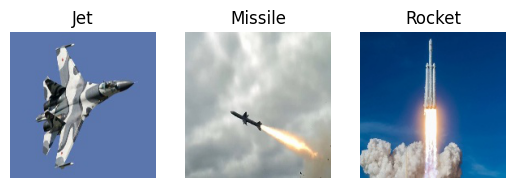

In [7]:
i = 1
names = ['Jet','Missile','Rocket']
for image_path in ['/content/data/train/fighter-jet/00000001.jpg','/content/data/test/missile/00000001.jpg','/content/data/train/rocket/00000001.jpg']:
  plt.subplot(1,3,i)
  image = plt.imread(image_path)
  plt.imshow(image)
  plt.axis('off')
  plt.title(names[i-1])
  i += 1

plt.show

# Neural Network architecture

The first consideration for this image multi-class classification model, is to use a data augmentation layer to avoid overfitting. The following cell defines a series of transformations for further use in our model.

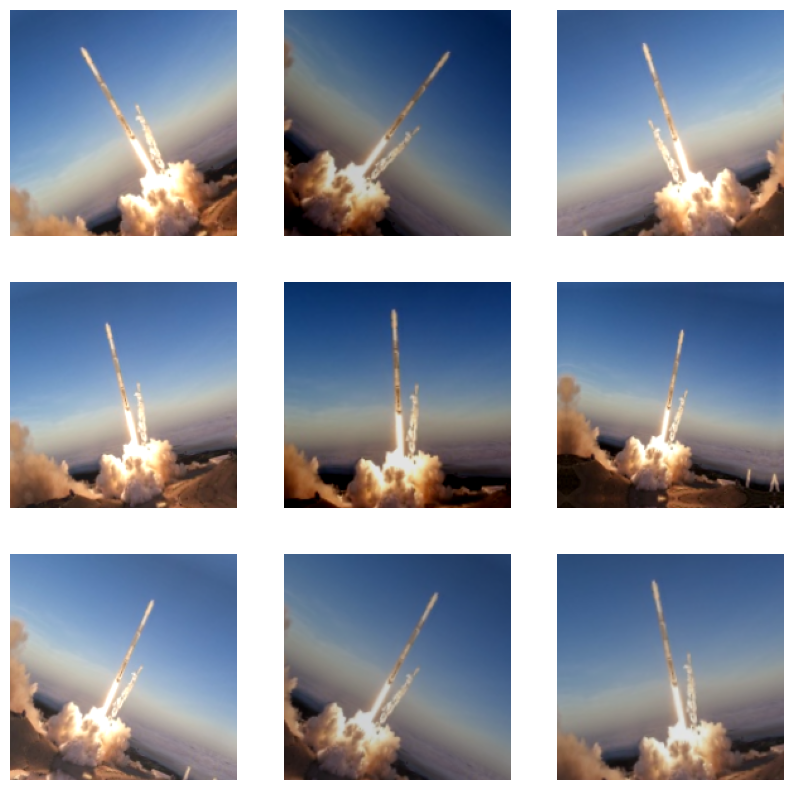

In [8]:
# Defines a sequence of transformations to perform Data Augmentation.
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
     layers.RandomContrast(0.2),
     layers.RandomBrightness(0.2)
    ]
)

# Shows the result of applying the data aumgentation layer to an image on the train dataset.

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

The best results were achieved using a pre-trained convolutional base connected directly to the output layer containing 3 neurons, which serves as a classifier. The convolutional base used was VGG16, which has been trained on the Imagenet dataset.

In [9]:
# The convolutional base is defined using the VGG16 architecture.
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet", # Initializes the pretrained weights from the Imagenet database.
 include_top=False, # Dismiss the usage of the pre-trained classifier.
 input_shape=(180, 180, 3)) # Sets the shape of the input to the convolutional base.

# Freezes the weights of the convolutional base.
conv_base.trainable = False

# Shows a summary of the VGG16 convolutional base.
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Now, we attach the convolutional base to our own classifier, in order to train it using our dataset. A data augmentation layer is applied to the inputs in order to avoid overfitting. A dropout layer is applied after flattening the output of the convolutional base, serving the same objective of reducing overfitting.

In [10]:
# Defines the shape of the input variable.
inputs = keras.Input(shape=(180, 180, 3))

# Applies data augmentation to the inputs.
x = data_augmentation(inputs)

# Pre-processes the input to normalize the values of the pixels,
# which range from o to 255, in order to fit them from 0 to 1.
x = keras.applications.vgg16.preprocess_input(x)

# Applies the convolutional base transformations.
x = conv_base(x)

# Reshapes the output to a 1D layer.
x = layers.Flatten()(x)

# Applies a 50% dropout.
x = layers.Dropout(0.5)(x)

# Connects the output layer to a dense neuron layer consisting of 3 neurons.
# The softmax activation function is used, since this is a multi-class classification.
outputs = layers.Dense(3, activation="softmax")(x)

# Creates the model using the above defined inputs and outputs.
model = keras.Model(inputs, outputs)

# Compiles the model.
model.compile(loss="sparse_categorical_crossentropy",
 optimizer="Adam",
 metrics=["accuracy"])

# Shows a summary of the model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

# Training the model

We fit the model to our training dataset. Two callbacks from Keras are used in order to control the training: Model Checkpoint and Early Stopping. The former saves the model that presents the lowest validation loss, and will be used to evaluate the accuracy of the model using the test dataset, the latter will stop the training if the validation loss does not continue to go down after 3 epochs.

Epoch 1/20
16/16 [==============================] - 13s 331ms/step - loss: 5.7214 - accuracy: 0.6291 - val_loss: 3.5299 - val_accuracy: 0.8173
Epoch 2/20
16/16 [==============================] - 4s 208ms/step - loss: 3.0520 - accuracy: 0.8145 - val_loss: 4.7933 - val_accuracy: 0.8413
Epoch 3/20
16/16 [==============================] - 4s 206ms/step - loss: 2.7381 - accuracy: 0.8320 - val_loss: 3.7550 - val_accuracy: 0.8510
Epoch 4/20
16/16 [==============================] - 4s 213ms/step - loss: 2.0227 - accuracy: 0.8607 - val_loss: 2.9589 - val_accuracy: 0.8462
Epoch 5/20
16/16 [==============================] - 4s 214ms/step - loss: 1.9162 - accuracy: 0.8658 - val_loss: 2.6999 - val_accuracy: 0.8606
Epoch 6/20
16/16 [==============================] - 4s 209ms/step - loss: 1.7422 - accuracy: 0.8873 - val_loss: 4.7993 - val_accuracy: 0.8510
Epoch 7/20
16/16 [==============================] - 3s 203ms/step - loss: 1.6147 - accuracy: 0.8893 - val_loss: 3.1887 - val_accuracy: 0.8702
Epoch

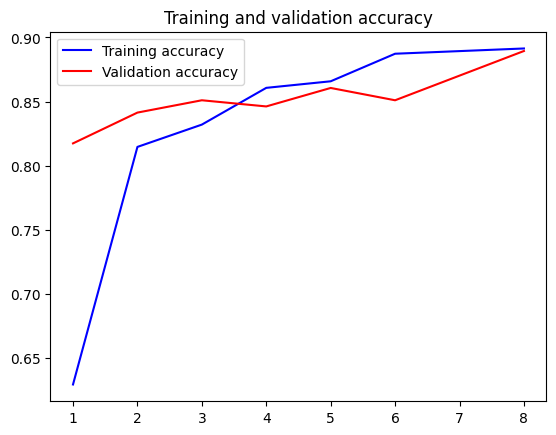

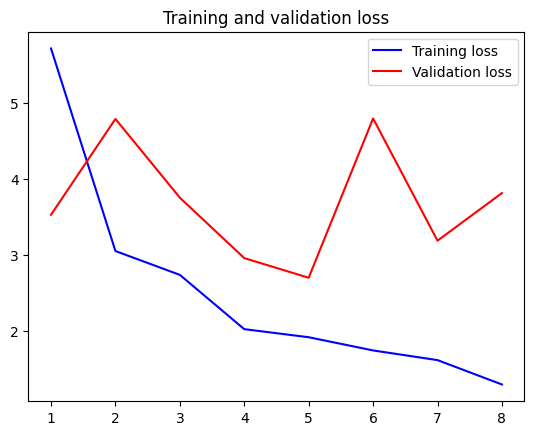

In [11]:
# Defines our callback list.
callbacks = [
 keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"),

 keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 3
    )
]

# Fits the model to our dataset during at most 20 epochs.
history = model.fit(
 train_dataset,
 epochs=20,
 validation_data=validation_dataset,
 callbacks=callbacks)

# Visualizes the training loss and accuracy as a function of the training epoch.
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "b-", label="Training accuracy")
plt.plot(epochs, val_acc, "r-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b-", label="Training loss")
plt.plot(epochs, val_loss, "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing the model

We test our classifier on the test dataset using the weights provided by the Model Checkpoint callbakc, and then we obtain the confusion matrix.

In [12]:
# Tests the model using the test dataset.
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

4/4 [==============================] - 3s 816ms/step - loss: 2.1012 - accuracy: 0.8925
Test accuracy: 0.893


In [13]:
# Prints the confusion matrix of the model.
test_images, test_labels = get_images_and_labels(test_dataset)

x_test = test_images
y_test = test_labels
y_pred = np.argmax(test_model.predict(x_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

7/7 [==============================] - 3s 71ms/step
[[94  5  0]
 [ 4 51  3]
 [ 0 11 46]]


# Fine-tuning the model.

Once our classifier was trained using the pre-trained convolutional base, we can fine-tune our model by allowing some of the last layers of the convolutional base in order to extract the specific characteristics of our dataset. We use a reduced learning rate to avoid getting rid of the capabilities of the pretrained model.

In [14]:
# Unfreezes the last 4 layers of the convolutional base.
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
 layer.trainable = False

# Compiles the model with the trained classifier.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
              metrics=["accuracy"])

# Shows a summary of the model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

Observe that this summary confirms that thereare now more trainable parameters. Now, we train the model using the Model Checkpoint callback only.

Epoch 1/30
16/16 [==============================] - 8s 269ms/step - loss: 1.1862 - accuracy: 0.8965 - val_loss: 3.5105 - val_accuracy: 0.8606
Epoch 2/30
16/16 [==============================] - 5s 252ms/step - loss: 1.2585 - accuracy: 0.8934 - val_loss: 2.9932 - val_accuracy: 0.8798
Epoch 3/30
16/16 [==============================] - 4s 248ms/step - loss: 1.0141 - accuracy: 0.9129 - val_loss: 2.8821 - val_accuracy: 0.8798
Epoch 4/30
16/16 [==============================] - 4s 264ms/step - loss: 0.9311 - accuracy: 0.9139 - val_loss: 2.6421 - val_accuracy: 0.8846
Epoch 5/30
16/16 [==============================] - 5s 284ms/step - loss: 0.8649 - accuracy: 0.9139 - val_loss: 2.6994 - val_accuracy: 0.8798
Epoch 6/30
16/16 [==============================] - 6s 331ms/step - loss: 0.6952 - accuracy: 0.9211 - val_loss: 2.3917 - val_accuracy: 0.9087
Epoch 7/30
16/16 [==============================] - 4s 233ms/step - loss: 0.7859 - accuracy: 0.9109 - val_loss: 2.4122 - val_accuracy: 0.8942
Epoch 

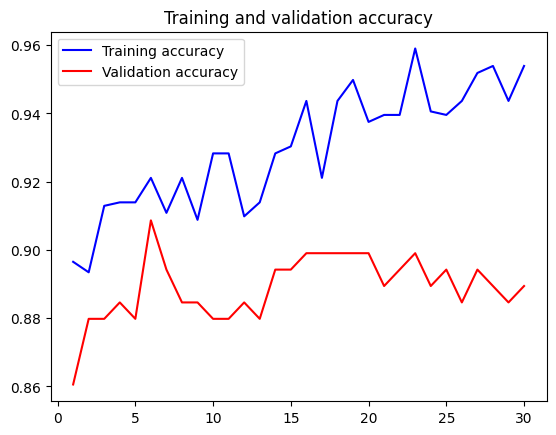

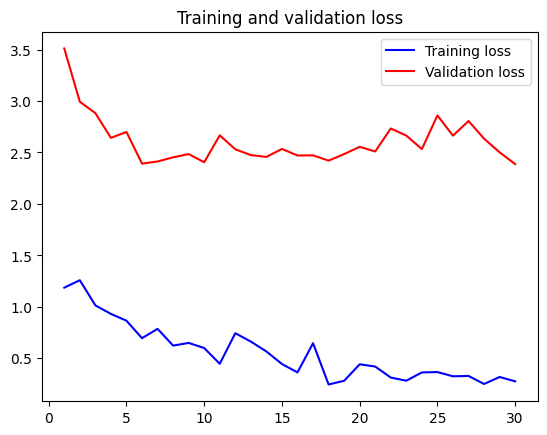

In [15]:
# Defines our callback list.
callbacks = [
 keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Fits the model to our dataset during at most 30 epochs.
history_tuning = model.fit(
 train_dataset,
 epochs=30,
 validation_data=validation_dataset,
 callbacks=callbacks)

# Visualizes the training loss and accuracy as a function of the training epoch.
acc = history_tuning.history["accuracy"]
val_acc = history_tuning.history["val_accuracy"]
loss = history_tuning.history["loss"]
val_loss = history_tuning.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "b-", label="Training accuracy")
plt.plot(epochs, val_acc, "r-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b-", label="Training loss")
plt.plot(epochs, val_loss, "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
# Tests the model using the test dataset.
test_model = keras.models.load_model(
 "fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

4/4 [==============================] - 1s 141ms/step - loss: 1.3035 - accuracy: 0.9112
Test accuracy: 0.911


In [17]:
# Prints the confusion matrix of the model.
test_images, test_labels = get_images_and_labels(test_dataset)

x_test = test_images
y_test = test_labels
y_pred = np.argmax(test_model.predict(x_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

7/7 [==============================] - 1s 85ms/step
[[93  6  0]
 [ 3 49  6]
 [ 0  4 53]]


# Conclusions

The pre-trained convolutional base with our neural network classifier obtained an accuracy of $89\%$ on the train dataset. We achieved a slightly better performance by fine-tuning the last layers of the convolutional base, getting an accuracy of $91\%$.

The impossibility to get a greater accuracy might be due to the noisy dataset, which still includes some pictures where the objects cannot be identified clearly. On the other hand, another source of error might be that the images from the **missile** and **rocket** classes are similar.

In any case, this exercise demonstrate the power of convolutional neural networks for classification tasks involving images. In particular, we have leveraged the benefits of using a pre-trained model and fine-tuning it for our particular purpose.

# References

[1] Chollet, F. (2021). *Deep Learning with Python*. Manning.

[2] *flying-planes*, Kaggle. https://www.kaggle.com/datasets/eabdul/flying-vehicles